In [1]:
import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio.plot
from rasterio.transform import rowcol
from sklearn.metrics import confusion_matrix
from typing import Optional, List, Callable

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.area_utils import (
    binarize,
    load_raster,
    compute_area_estimate,
    create_area_estimate_summary,
    create_confusion_matrix_summary,
)

In [3]:
country_iso_code = 'ETH' # Can be found https://www.iso.org/obp/ui/#search under the Alpha-3 code column
adm1_of_interest = ['Tigray']

gadm2_path = f'https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_{country_iso_code}_2.json.zip'
roi = gpd.read_file(gadm2_path)
roi = roi.query('NAME_1 in @adm1_of_interest')
roi.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
74,ETH.11.1_1,ETH,Ethiopia,ETH.11_1,Tigray,NA,Debubawi,Southern,NA,Zone,Zone,0104,NA,"MULTIPOLYGON (((39.24060 12.43220, 39.23620 12..."
75,ETH.11.2_1,ETH,Ethiopia,ETH.11_1,Tigray,NA,Mehakelegnaw,Central,NA,Zone,Zone,0102,NA,"MULTIPOLYGON (((38.73750 13.31740, 38.73690 13..."
76,ETH.11.3_1,ETH,Ethiopia,ETH.11_1,Tigray,NA,Mi'irabawi,Western,NA,Zone,Zone,0105,NA,"MULTIPOLYGON (((37.74610 13.57090, 37.73570 13..."
77,ETH.11.4_1,ETH,Ethiopia,ETH.11_1,Tigray,NA,Misraqawi,Eastern,NA,Zone,Zone,0103,NA,"MULTIPOLYGON (((39.66980 13.59600, 39.65460 13..."
78,ETH.11.5_1,ETH,Ethiopia,ETH.11_1,Tigray,NA,SemienMi'irabaw,NorthWestern,NA,Zone,Zone,0101,NA,"MULTIPOLYGON (((38.70570 13.38930, 38.66910 13..."


In [4]:
# Optionally restrict ROI to an admin2 boundary
adm2_of_interest = ["SemienMi'irabaw"]
roi = roi.query('NAME_2 in @adm2_of_interest')

In [5]:
# Merge selected region(s) into a single polygon
roi = roi.dissolve()

In [6]:
# Optionally define a shapefile to use instead
# shape_fn = "fao-tigray-boundary.shp"
# roi = gpd.read_file(shape_fn)

<Axes: >

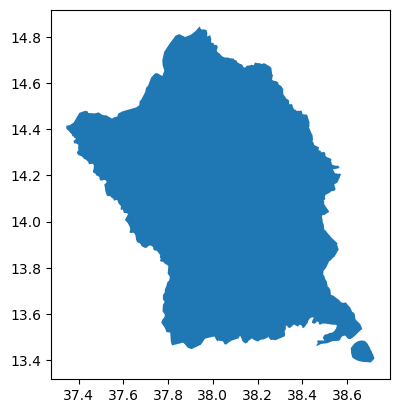

In [7]:
roi.plot()

In [8]:
fn = lambda y : f"Ethiopia_Tigray_{y}_threshold-3-5.tif"

In [10]:
cropmap_y1, y1_meta = load_raster(fn(2020), roi)
cropmap_y2, y2_meta = load_raster(fn(2021), roi)

                
 You need to project the map to the local UTM Zone                 (EPSG:XXXXX).
Input EPSG Code; EPSG:XXXX:32637
Clipping to boundary.
The pixel size is 9.798 meters
                
 You need to project the map to the local UTM Zone                 (EPSG:XXXXX).
Input EPSG Code; EPSG:XXXX:32637
Clipping to boundary.
The pixel size is 9.798 meters


In [11]:
cropmask_y1 = binarize(cropmap_y1, y1_meta)
cropmask_y2 = binarize(cropmap_y2, y2_meta)

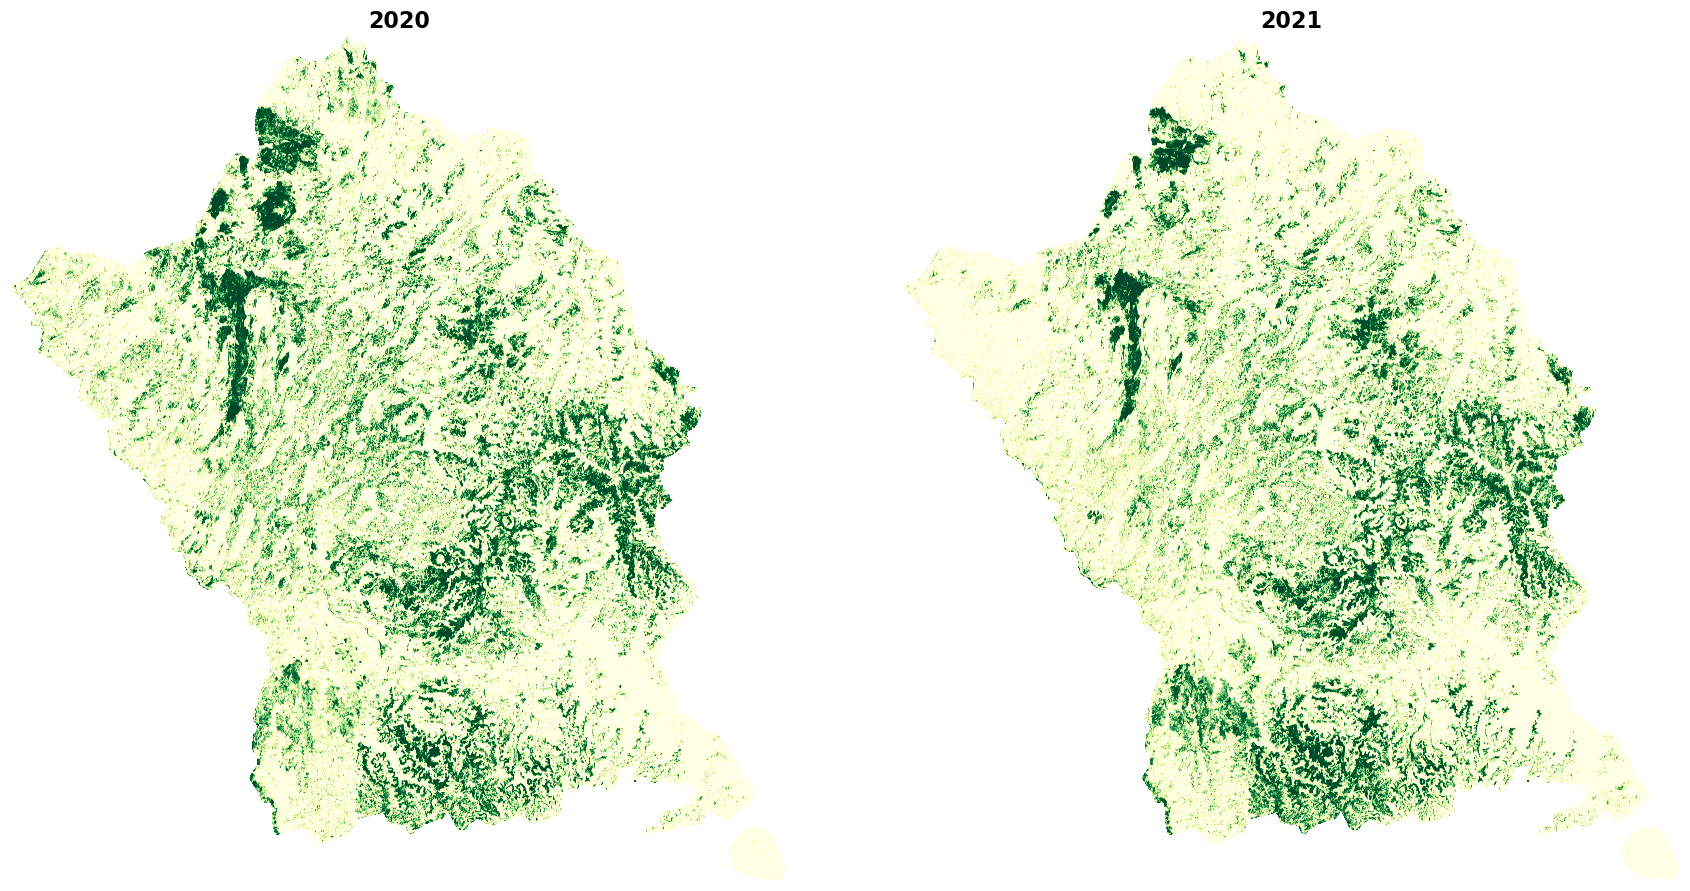

In [12]:
# Plot each crop-mask 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 9))
axes[0].imshow(cropmask_y1, cmap = 'YlGn', vmin = 0, vmax = 1)
axes[1].imshow(cropmask_y2, cmap = 'YlGn', vmin = 0, vmax = 1)
axes[0].set_title("2020", fontsize = 16, fontweight = "semibold")
axes[1].set_title("2021", fontsize = 16, fontweight = "semibold")
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()

In [13]:
# Calculate change map
change_map = cropmask_y1 * 2 + cropmask_y2
change_meta = y1_meta.copy()

In [14]:
# Alternatively, load change map in from file

# change_map_fn = "tigray-change-threshold-3-5.tif"
# change_map, change_meta = load_raster(change_map_fn)

In [15]:
# Check that the unique values are 0, 1, 2, 3, 255/nodata
np.unique(change_map.flatten())

masked_array(data=[0, 1, 2, 3, --],
             mask=[False, False, False, False,  True],
       fill_value=255,
            dtype=uint8)

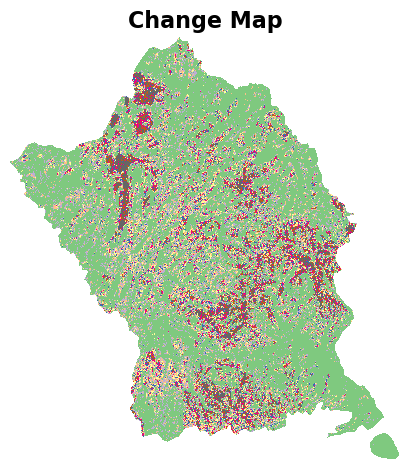

In [16]:
# Visualize the change map
# -> Green (0) : Stable NP
# -> Gray (3) : Stable P
plt.imshow(change_map, cmap='Accent')
plt.axis("off")
plt.title("Change Map", fontsize = 16, fontweight = "semibold")
plt.tight_layout()

In [17]:
# Save change-map

with rio.open("tigray-change-threshold-3-5-central.tif", "w", **change_meta) as dst:
    dst.write(np.expand_dims(change_map, 0))

In [18]:
pixel_size = change_meta["transform"][0]
print("Pixel Size - {:.2f} meters".format(pixel_size))

Pixel Size - 9.80 meters


In [19]:
stable_np_px = np.where(change_map.data.flatten() == 0)[0].shape[0]
p_gain_px = np.where(change_map.data.flatten() == 1)[0].shape[0]
p_loss_px = np.where(change_map.data.flatten() == 2)[0].shape[0]
stable_p_px = np.where(change_map.data.flatten() == 3)[0].shape[0]
total_px = np.where(change_map.data.flatten() != change_map.fill_value)[0].shape[0] # Do not count masked values

In [20]:
# Load in labeled reference samples
ref_sample_path = '/Users/hkerner/data/fewsnet/tigray/tigray_labels/change_2020-2021_strat_ref_samples_labeled.shp'
gdf = gpd.read_file(ref_sample_path).set_crs("EPSG:4326")
gdf = gdf.to_crs(change_meta["crs"])
gdf.head()

,plotid,sampleid,lon,lat,email,flagged,collection,analysis_d,imagery_ti,imagery_at,sample_geo,pl_samplei,Was this a,Was this_1,Change cla,geometry
0,0,0,38.044465,14.466000,hkerner@umd.edu,0,2021-11-17 15:37,216.4 secs,Planet Monthly Mosaics,NaN,POINT(38.04446549084796 14.46600000567765),0,Not planted,Not planted,0,POINT (397018.203 1599479.121)
1,1,1,37.699107,14.490831,hkerner@umd.edu,0,2021-11-21 08:57,14.5 secs,Planet Monthly Mosaics,NaN,POINT(37.699106684514234 14.490830516370108),1,Planted,Planted,3,POINT (359808.203 1602409.121)
2,2,2,39.751425,14.478674,hkerner@umd.edu,0,2021-11-17 15:45,191.5 secs,Planet Monthly Mosaics,NaN,POINT(39.75142468697266 14.478674222387781),2,Not planted,Not planted,0,POINT (580978.203 1600799.121)
3,3,3,38.113275,14.119644,hkerner@umd.edu,0,2021-11-17 15:47,71.2 secs,Planet Monthly Mosaics,NaN,POINT(38.113274682684654 14.119644281322522),3,Planted,Planted,3,POINT (404288.203 1561139.121)
4,4,4,38.768685,14.439435,hkerner@umd.edu,0,2021-11-17 15:48,51.3 secs,Planet Monthly Mosaics,NaN,POINT(38.7686845624209 14.439435434528004),4,Not planted,Not planted,0,POINT (475068.203 1596339.121)


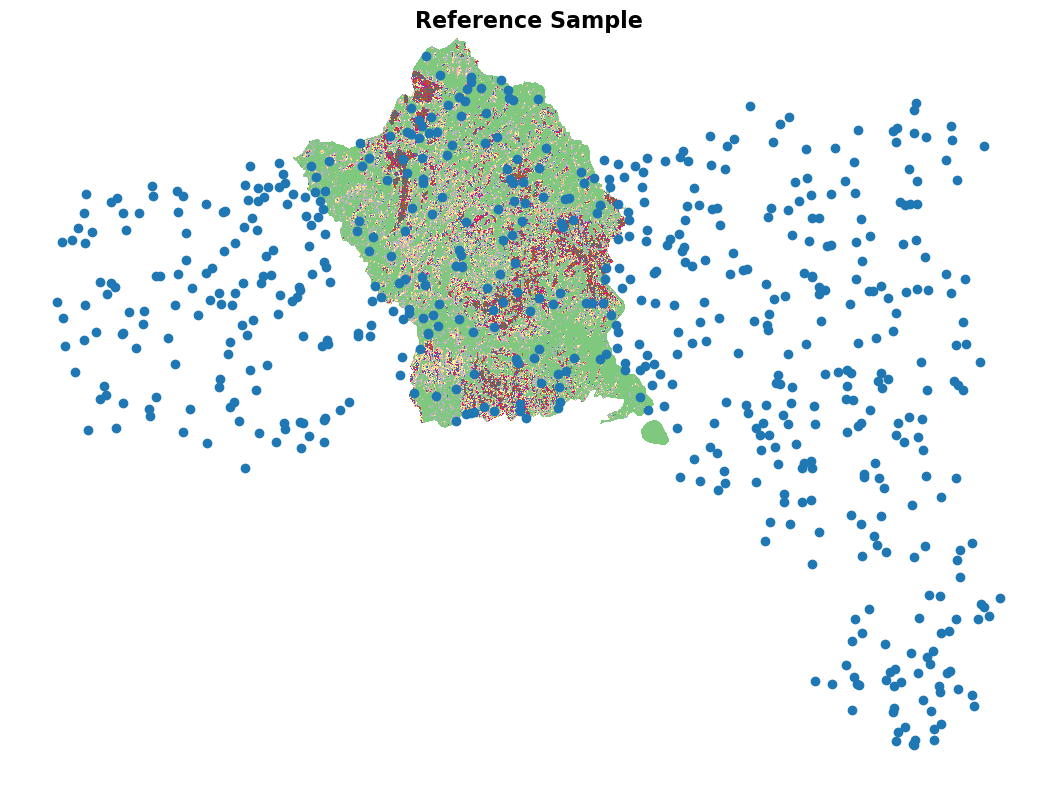

In [21]:
# Overlay labeled reference sample onto change map

raster = rio.open("tigray-change-threshold-3-5-central.tif")
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))
rasterio.plot.show(raster, cmap = "Accent", ax = ax)
gdf.plot(ax = ax)
ax.set_axis_off()
plt.title("Reference Sample", fontsize = 16, fontweight = "semibold")
plt.tight_layout()

In [22]:
# Extract predictions from map for comparison with reference sample
for r, row in gdf.iterrows():
    geometry = row["geometry"]
    x, y = geometry.x, geometry.y
    try:
        px, py = rowcol(change_meta["transform"], x, y)
        gdf.loc[r, "Mapped class"] = change_map[px,py]
    except IndexError:
        gdf.loc[r, "Mapped class"] = None

/Users/hkerner/anaconda3/envs/landcover-mapping/lib/python3.8/site-packages/pandas/core/internals/blocks.py:953: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value


In [23]:
# How many out of bounds reference-sample points
print(f"Number of out of bound samples: {gdf['Mapped class'].isna().sum()}")

Number of out of bound samples: 381


In [24]:
# Remove out of bound points
gdf = gdf[~gdf["Mapped class"].isna()]
gdf["Mapped class"] = gdf["Mapped class"].astype(np.uint8)

/Users/hkerner/anaconda3/envs/landcover-mapping/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [25]:
# Compute confusion matrix
y_true = np.array(gdf['Change cla']).astype(np.uint8)
y_pred = np.array(gdf['Mapped class']).astype(np.uint8)
cm = confusion_matrix(y_true, y_pred) 
print(cm) # Colums - predictions, Rows - actual
# Stable NP, PGain, PLoss, Stable P

[[128   6   7  11]
 [  0   2   0   1]
 [  1   0   0   1]
 [ 26   1   8  27]]


In [26]:
def plot_confusion_matrix(cm,labels) -> None:
    """Pretty prints confusion matrix.

    Expects row 'Reference' and column 'Prediction/Map' ordered confusion matrix.

    Args:
        cm:
            Confusion matrix of reference and map samples expressed in terms of
            sample counts, n[i,j]. Row-column ordered reference-row, map-column.
        labels:
            List-like containing labels in same order as confusion matrix. For
            example:

            ["Stable NP", "PGain", "PLoss", "Stable P"]

            ["Non-Crop", "Crop"]

    """

    _, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(cm, cmap="crest", annot=True, fmt="d", cbar=False, square=True, ax=ax)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_coords(0.50, 1.125)
    ax.yaxis.set_label_coords(-0.125, 0.50)
    ax.set_xticklabels(labels=labels)
    ax.set_yticklabels(labels=labels)
    ax.set_xlabel("Map", fontsize=12)
    ax.set_ylabel("Reference", fontsize=12)
    plt.tight_layout()

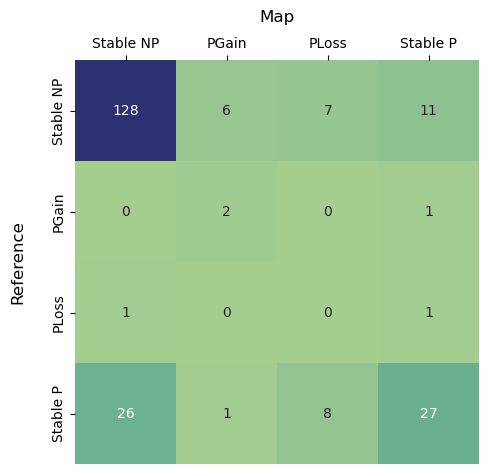

In [27]:
# Pretty print confusion matrix
plot_confusion_matrix(cm, labels = ["Stable NP", "PGain", "PLoss", "Stable P"])

In [28]:
cm_summary = create_confusion_matrix_summary(cm, columns = ["Stable NP", "PGain", "PLoss", "Stable P"])

                     Stable NP  PGain  PLoss  Stable P
False Positive Rate       0.40   0.03   0.07      0.08
True Positive Rate        0.84   0.67   0.00      0.44
Accuracy                  0.69   0.01   0.01      0.28


In [29]:
# total_px_area = change_map.flatten().shape[0] # <- Overcounts!
# Marginal pixel total of mapped classes
a_j = np.array([stable_np_px, p_gain_px, p_loss_px, stable_p_px], dtype = np.int64)

In [30]:
estimates = compute_area_estimate(cm, a_j, px_size = pixel_size)

In [31]:
u_j, err_u_j = estimates["user"]
print(f"User's accuracy and 95% CI\n{u_j.round(2)}\n{(err_u_j).round(2)}")

User's accuracy and 95% CI
[0.83 0.22 0.   0.68]
[0.06 0.29 0.   0.15]


In [32]:
p_i, err_p_i = estimates["producer"]
print(f"Producer's accuracy and 95% CI\n{p_i.round(2)}\n{(err_p_i).round(2)}")

Producer's accuracy and 95% CI
[0.84 0.77 0.   0.37]
[0.04 0.42 0.   0.08]


In [33]:
acc, err_acc = estimates["accuracy"]
print(f"Overall accuracy and 95% CI\n{acc.round(2)} \u00B1 {(err_acc).round(2)}")

Overall accuracy and 95% CI
0.71 ± 0.05


In [34]:
a_ha, err_ha = estimates["area"]["ha"]
print(f"Estimated area [ha] and 95% CI of area [ha] \n{np.stack([a_ha, err_ha]).round(2)}")

Estimated area [ha] and 95% CI of area [ha] 
[[891436.18  19319.72  10408.98 334459.  ]
 [ 68842.79  21127.66  14544.73  66738.4 ]]


In [35]:
summary = create_area_estimate_summary(a_ha, err_ha, u_j, err_u_j, p_i, err_p_i, columns = ["Stable NP", "PGain", "PLoss", "Stable P"])

                     Stable NP     PGain     PLoss   Stable P
Estimated area [ha]  891436.18  19319.72  10408.98  334459.00
95% CI of area [ha]   68842.79  21127.66  14544.73   66738.40
User's accuracy           0.83      0.22      0.00       0.68
95% CI of user acc.       0.06      0.29      0.00       0.15
Producer's accuracy       0.84      0.77      0.00       0.37
95% CI of prod acc.       0.04      0.42      0.00       0.08
